# Random Forest 

Richard Hsu 7-23-16

In [1]:
import io, os, sys, types
from sklearn import cross_validation
from sklearn import neighbors
from sklearn import grid_search
from sklearn import metrics
from sklearn import linear_model

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1)
%matplotlib inline

In [2]:
import nbformat

from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [4]:
class NotebookLoader(object):
    """Module Loader for IPython Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing notebook from %s" % path)
                                       
        # load the notebook object
        nb = nbformat.read(path, as_version=4)
        
        
        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [5]:
class NotebookFinder(object):
    """Module finder that locates IPython Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [6]:
sys.meta_path.append(NotebookFinder())

importing notebook from EDA.ipynb
['Station' 'Date' 'Tmax' 'Tmin' 'Tavg' 'Depart' 'DewPoint' 'WetBulb' 'Heat'
 'Cool' 'Sunrise' 'Sunset' 'CodeSum' 'Depth' 'Water1' 'SnowFall'
 'PrecipTotal' 'StnPressure' 'SeaLevel' 'ResultSpeed' 'ResultDir'
 'AvgSpeed']
Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64
Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall      

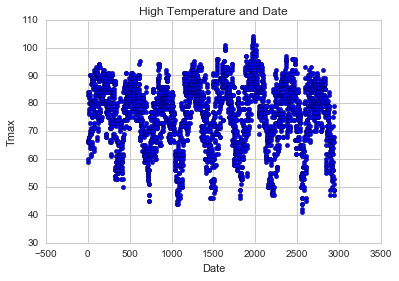

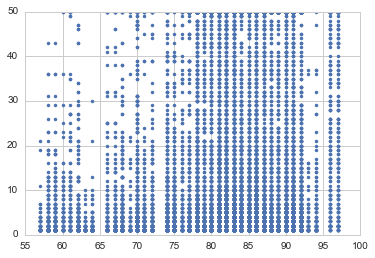

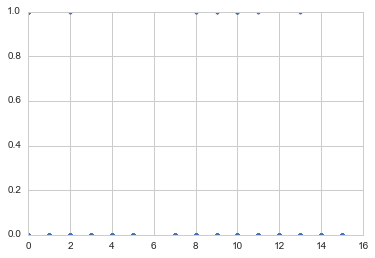

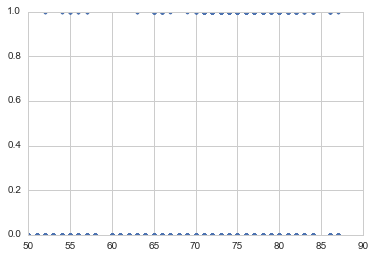

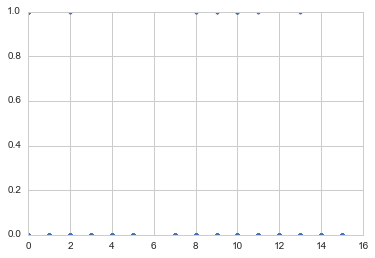

Numerical columns:
set(['AddressNumberAndStreet_7900  S CHICAGO AVE, Chicago, IL', 'Street_ E 111TH ST', 'Street_ S CALIFORNIA', 'Trap_T081', 'Address_5800 North Pulaski Road, Chicago, IL 60646, USA', 'Trap_T083', 'Station', 'Trap_T085', 'Trap_T084', 'Trap_T086', 'AddressNumberAndStreet_1100  S STATE ST, Chicago, IL', 'Trap_T088', 'Address_6500 North Oak Park Avenue, Chicago, IL 60631, USA', 'Address_1100 Roosevelt Road, Chicago, IL 60608, USA', 'Tmin', 'Trap_T160', 'Trap_T161', 'Street_ W GRANVILLE AVE', 'StnPressure', 'AddressNumberAndStreet_1500  N LONG AVE, Chicago, IL', 'Street_ S AVENUE G', 'Street_ S CORNELL AVE', 'Address_3900 North Springfield Avenue, Chicago, IL 60618, USA', 'Street_ S AVENUE L', 'Street_ W GREENLEAF AVE', 'AddressNumberAndStreet_2100  S HAMLIN AVE, Chicago, IL', 'AddressNumberAndStreet_2500  S THROOP, Chicago, IL', 'Street_ W MONTROSE DR', 'Trap_T018', 'Trap_T019', 'Street_ S STONY ISLAND AVE', 'Trap_T012', 'Trap_T013', 'AddressNumberAndStreet_1300  S TORREN

In [7]:
import EDA

In [8]:
EDA.joined_data.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,M,M,M,0.00,29.44,30.09,5.8,16,7.4
2,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
3,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,M,M,M,0.00,29.44,30.09,5.8,16,7.4
4,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5


In [9]:
from sklearn import tree

# Set features to use
features = ['Tavg', 'Heat'] 

# Set target variable name
target = 'WnvPresent'

# Set X and y
X = EDA.joined_data[features]
y = EDA.joined_data[target]

# Create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=42)

# Instantiate model using default params
tm = tree.DecisionTreeClassifier()

# Train model on training set
tm.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % tm.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, tm.predict_proba(X_test)[:,1])



Accuracy: 0.946
ROC AUC: 0.680


I got a great accuracy here with only two features. 

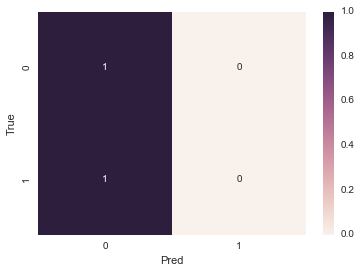

Confusion Matrix:
[[7947    0]
 [ 458    0]]


In [10]:
# Get confusion matrix on test set
y_pred = tm.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

A heat map of the confusion matrix supports the strength of the model because we accurately predict what the actual value is almost all the time. This leads to some suspicions that the model is overfitting the data. 

## Check if the model is overfit by checking accuracy on training set vs test set

### Check if the model is overfit by checking accuracy on training set vs test set

In [11]:
# Evaluate model on train set
print "Accuracy: %0.3f" % tm.score(X_train, y_train)

# Evaluate model on test set
print "Accuracy: %0.3f" % tm.score(X_test, y_test)

Accuracy: 0.949
Accuracy: 0.946


A close look at the accuracies of the training set and test set show that the accuracy are both relatively close to each other. This indicates that we are less likely to be overfitting. 

### Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

In [12]:
# Instantiate model using default params
tm = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)

# Train model on training set
tm.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [13]:
# Evaluate model on train set
print "Accuracy: %0.3f" % tm.score(X_train, y_train)

# Evaluate model on test set
print "Accuracy: %0.3f" % tm.score(X_test, y_test)

Accuracy: 0.949
Accuracy: 0.946


Further, adusting the max_depth and the minimum number of records does not change the accuract very much. 

## Random Forests

In [14]:
from sklearn import ensemble

# Instantiate model
rf = ensemble.RandomForestClassifier(n_estimators=20, class_weight="balanced")

# Train model on training set
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
# Evaluate model on train set
print "Accuracy: %0.3f" % rf.score(X_train, y_train)

# Evaluate model on test set
print "Accuracy: %0.3f" % rf.score(X_test, y_test)

Accuracy: 0.526
Accuracy: 0.529


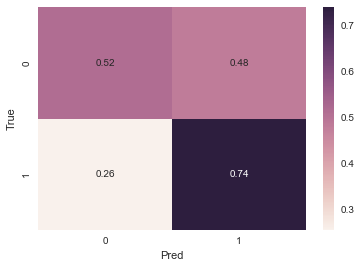

Confusion Matrix:
[[4105 3842]
 [ 118  340]]


In [16]:
# Get confusion matrix on test set
y_pred = rf.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

To improve the model, we used a series of decision trees forming a random forest. The accuracy has not improved much after this. 

Best Params:
{'n_estimators': 1}
Accuracy of current model: 0.529
Accuracy using best param: 0.949


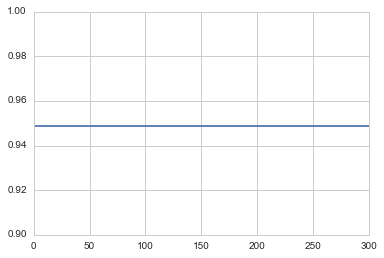

In [17]:
# Set list of values to grid search over
n = [1, 2, 3, 10, 20, 30, 100, 200, 300]
params = {'n_estimators': n}

# Perform grid search using list of values
gs = grid_search.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(),
    param_grid=params)
gs.fit(X_train, y_train)

# Get best value to use
print "Best Params:"
print gs.best_params_

# Get improvement
print "Accuracy of current model: %0.3f" % rf.score(X_test, y_test)
print "Accuracy using best param: %0.3f" % gs.best_score_

# Plot scores
plt.plot(n, [s[1] for s in gs.grid_scores_])

In [18]:
# Current model params
print rf
print "Accuracy of current model: %0.3f" % rf.score(X_test, y_test)

# Update model params
rf.set_params(n_estimators=gs.best_params_['n_estimators'])

# Retrain model on new params
rf.fit(X_train, y_train)

# Updated model params
print rf
print "Accuracy of updated model: %0.3f" % rf.score(X_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of current model: 0.529
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of updated model: 0.492


### Extract Feature Importances

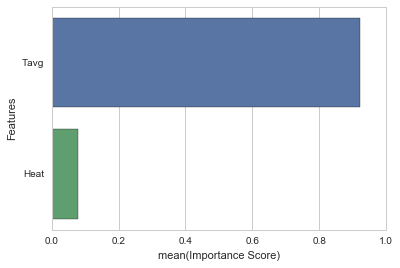

In [19]:
# Plot importances for all features
features = X.columns
feature_importances = rf.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

sns.barplot(y='Features', x='Importance Score', data=features_df)

A close look at the features suggest that Tavg contributes the most in the prediction process. This suggests that we need to use more features and not rely on the two that was used to avoid having just one feature predicting everything. 

## Feature Engineering

In [20]:
# Set features to use
features = ['Tavg', 'Heat'] + \
           filter(lambda x: x.startswith('Species_'), EDA.final_numeric_data.columns) + \
           filter(lambda x: x.startswith('AddressNumberAndStreet_'), EDA.final_numeric_data.columns)

# Set target variable name
target = 'WnvPresent'

# Set X and y
X = EDA.final_numeric_data[features]
y = EDA.final_numeric_data[target]

# Create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=42)

# Instantiate model using default params
tm = tree.DecisionTreeClassifier(class_weight="balanced")

# Train model on training set
tm.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % tm.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, tm.predict_proba(X_test)[:,1])

Accuracy: 0.837
ROC AUC: 0.679


In additon to Tavg and Heat, this time, we are also looking at the species of the mosquitos. 

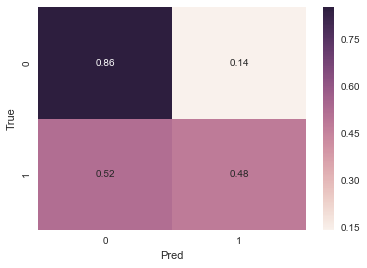

Confusion Matrix:
[[6815 1132]
 [ 239  219]]


In [21]:
# Get confusion matrix on test set
y_pred = tm.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

In [22]:
# Evaluate model on train set
print "Accuracy: %0.3f" % tm.score(X_train, y_train)

# Evaluate model on test set
print "Accuracy: %0.3f" % tm.score(X_test, y_test)

Accuracy: 0.872
Accuracy: 0.837


key parameters
1. n_estimators: Number of trees in the forest.
2. criterion: Function to measure the quality of split. 
3. max_features
4. max_depth
5. min_samples_split
6. min_weight_fraction_leaf
7. max_leaf_nodes

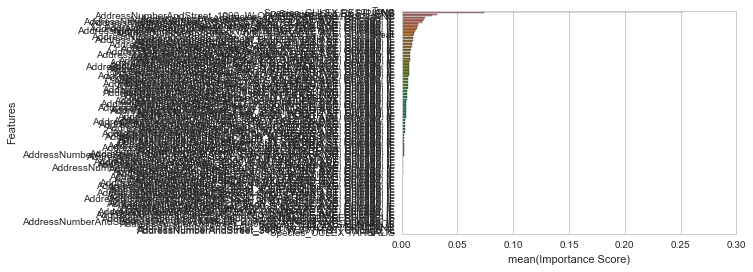

In [29]:
# Plot importances for all features
features = X.columns
feature_importances = tm.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

sns.barplot(y='Features', x='Importance Score', data=features_df)

In [26]:
print features

Index([u'Tavg', u'Heat', u'Species_CULEX ERRATICUS', u'Species_CULEX PIPIENS',
       u'Species_CULEX PIPIENS/RESTUANS', u'Species_CULEX RESTUANS',
       u'Species_CULEX SALINARIUS', u'Species_CULEX TARSALIS',
       u'Species_CULEX TERRITANS',
       u'AddressNumberAndStreet_1000  E 67TH ST, Chicago, IL',
       ...
       u'AddressNumberAndStreet_8200  S KOSTNER AVE, Chicago, IL',
       u'AddressNumberAndStreet_8900  S CARPENTER ST, Chicago, IL',
       u'AddressNumberAndStreet_8900  S MUSKEGON AVE, Chicago, IL',
       u'AddressNumberAndStreet_9000  W GARFIELD BLVD, Chicago, IL',
       u'AddressNumberAndStreet_9100  W HIGGINS AVE, Chicago, IL',
       u'AddressNumberAndStreet_9100  W HIGGINS RD, Chicago, IL',
       u'AddressNumberAndStreet_9300  S DR MARTIN LUTHER KING JR DR, Chicago, IL',
       u'AddressNumberAndStreet_9600  S HOYNE AVE, Chicago, IL',
       u'AddressNumberAndStreet_9600  S LONGWOOD DR, Chicago, IL',
       u'AddressNumberAndStreet_9800  S AVENUE G, Chicago, I

The accuracy is about the same and looking at the feature importance, we can see that Tavg did come down suggesting that other features play a role in the prediction process. 

In [30]:
print feature_importances

[  2.52528860e-01   1.06518760e-02   0.00000000e+00   3.15027168e-02
   2.09267678e-02   7.39709567e-02   0.00000000e+00   0.00000000e+00
   0.00000000e+00   7.99516960e-03   6.42024981e-03   6.05251394e-04
   3.24540294e-03   1.86566759e-02   5.83805709e-03   8.19751516e-04
   2.76882030e-02   1.97035796e-02   6.34984050e-03   3.77457185e-03
   6.55348481e-03   4.30121936e-03   2.76221341e-03   4.69484245e-04
   2.60094660e-04   4.09586197e-03   5.33620918e-03   1.92530246e-02
   1.19647356e-03   1.12764682e-02   7.15717172e-03   9.91221175e-04
   4.18796093e-03   2.78239116e-03   8.70427465e-04   1.91889405e-04
   2.48593745e-03   9.27798598e-04   4.57489395e-03   1.00838525e-02
   1.52293302e-03   3.24263222e-04   7.39152346e-04   3.59394274e-04
   2.95773213e-03   2.04637621e-03   3.19881083e-04   0.00000000e+00
   7.06992215e-03   9.05047483e-03   9.62681891e-03   1.89274423e-03
   7.13498223e-03   6.02316700e-04   6.29875352e-03   5.74320071e-03
   0.00000000e+00   2.24971023e-03

In [31]:
# look at the top 10 features
features_list = features.tolist()
feature_importances_list = feature_importances.tolist()

features_dictionary = []
count = 0
for feature_importance in features_list:
    feature_info = []
    feature_info.append(feature_importance)
    feature_info.append(feature_importances[count])
    count += 1
    #print feature_info
    features_dictionary.append(feature_info)

In [32]:
# top 10 features
top_10_features = []
count = 0
# get the top 10 features
while count < 10:
    #top_10_features.append(features_dictionary[count])
    top_10_features.append(features_dictionary[count][0])
    count += 1

In [34]:
# Rerun model 
# Set features to use
features = top_10_features

# Set target variable name
target = 'WnvPresent'

# Set X and y
X = EDA.final_numeric_data[features]
y = EDA.final_numeric_data[target]

# Create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=42)

In [35]:
# Instantiate model
rf = ensemble.RandomForestClassifier(n_estimators=20, class_weight="balanced")

# Train model on training set
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
# Evaluate model on train set
print "Accuracy: %0.3f" % rf.score(X_train, y_train)

# Evaluate model on test set
print "Accuracy: %0.3f" % rf.score(X_test, y_test)

Accuracy: 0.597
Accuracy: 0.602


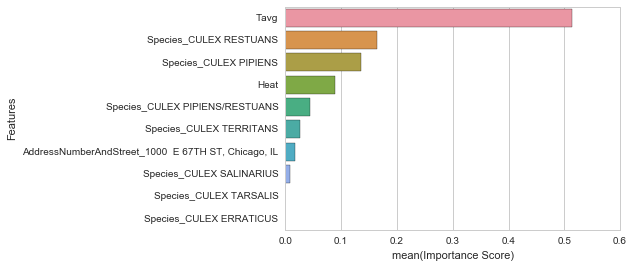

In [37]:
# Plot importances for all features
features = X.columns
feature_importances = rf.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

sns.barplot(y='Features', x='Importance Score', data=features_df)